In [1]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import pandas as pd

# Caminho do arquivo
file_path = "combined_data_with_classification.csv"

# Carregar o dataset
df = pd.read_csv(file_path)

# Exibir as primeiras linhas para análise
df.head()
# Remover colunas irrelevantes
df_cleaned = df.drop(columns=['Time', 'Source'])

# Separar entrada (variáveis de movimento) e saída (Mudra)
X = df_cleaned.drop(columns=['Mudra'])
y = df_cleaned['Mudra']

# Normalizar as variáveis de movimento
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Codificar os Mudras como tokens numéricos
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Converter para DataFrame novamente
df_processed = pd.DataFrame(X_scaled, columns=X.columns)
df_processed['Mudra'] = y_encoded

# Exibir amostras dos dados processados
df_processed.head()

,R_PositionX,R_PositionY,R_PositionZ,R_RotationX,R_RotationY,R_RotationZ,R_RotationW,R_CurlIndex,R_CurlMiddle,R_CurlRing,...,L_RotationX,L_RotationY,L_RotationZ,L_RotationW,L_CurlIndex,L_CurlMiddle,L_CurlRing,L_CurlPinky,L_CurlThumb,Mudra
0,0.471615,0.730263,0.952604,0.165737,0.443052,0.580202,0.731189,0.0,0.0,0.0,...,0.159486,0.548348,0.438654,0.739459,0.0,0.0,0.0,0.0,0.087998,1
1,0.466468,0.728169,0.959959,0.165396,0.454049,0.557253,0.733180,0.0,0.0,0.0,...,0.158458,0.551898,0.468558,0.740608,0.0,0.0,0.0,0.0,0.120933,1
2,0.463946,0.730463,0.961642,0.163535,0.453341,0.554497,0.730352,0.0,0.0,0.0,...,0.160713,0.541567,0.474051,0.745710,0.0,0.0,0.0,0.0,0.131379,1
3,0.453614,0.733241,0.959451,0.158962,0.451345,0.564089,0.720615,0.0,0.0,0.0,...,0.158216,0.541734,0.474162,0.741350,0.0,0.0,0.0,0.0,0.135019,1
4,0.452623,0.733653,0.958260,0.156610,0.448896,0.573692,0.714630,0.0,0.0,0.0,...,0.153730,0.551971,0.471711,0.732438,0.0,0.0,0.0,0.0,0.117391,1


In [2]:
import numpy as np

# Definir tamanho da sequência
seq_length = 10

# Converter DataFrame para arrays
X_array = df_processed.drop(columns=['Mudra']).values
y_array = df_processed['Mudra'].values

# Criar sequências de entrada e saída
X_seq = []
y_seq = []

for i in range(len(X_array) - seq_length + 1):
    X_seq.append(X_array[i:i + seq_length])
    y_seq.append(y_array[i:i + seq_length])

# Converter para arrays numpy
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Exibir forma das sequências criadas
X_seq.shape, y_seq.shape

((31992, 10, 24), (31992, 10))

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU



# Parâmetros do modelo
input_dim = 24  # Número de variáveis de movimento
seq_length = 10  # Número de frames por sequência
num_classes = len(label_encoder.classes_)  # Número de Mudras únicos
embed_dim = 64  # Dimensão do embedding
num_heads = 4  # Número de cabeças de atenção
ff_dim = 128  # Dimensão da feed-forward network
dropout_rate = 0.1  # Taxa de dropout

# Camada Transformer Encoder
def transformer_encoder(inputs, embed_dim, num_heads, ff_dim, dropout_rate):
    # Multi-Head Attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = Add()([inputs, attention_output])
    attention_output = LayerNormalization()(attention_output)
    
    # Feed-forward network
    ff_output = Dense(ff_dim, activation="relu")(attention_output)
    ff_output = Dense(embed_dim)(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    ff_output = Add()([attention_output, ff_output])
    return LayerNormalization()(ff_output)

# Definição do modelo
inputs = Input(shape=(seq_length, input_dim))
x = Dense(embed_dim)(inputs)  # Embedding inicial

# Adicionar camadas Transformer Encoder
for _ in range(2):  # Duas camadas
    x = transformer_encoder(x, embed_dim, num_heads, ff_dim, dropout_rate)

# Camada de saída para previsão de Mudras (softmax para classificação)
outputs = Dense(num_classes, activation="softmax")(x)

# Criar modelo
model = Model(inputs, outputs)

optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)  # Clip gradients
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
# Exibir resumo do modelo
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 24)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10, 64)    │      1,600 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 64)    │     66,368 │ dense[0][0],      │
│ (MultiHeadAttentio… │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 64)    │          0 │ dense[0][0],      │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 10, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 10, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 10, 64)    │      8,256 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 10, 64)    │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 10, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 10, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 10, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 10, 64)    │      8,256 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 10, 64)    │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 10, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 64)    │        128 │ add_3[0][0]     

 Total params: 168,845 (659.55 KB)

 Trainable params: 168,845 (659.55 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Camada Transformer Decoder
def transformer_decoder(inputs, encoder_outputs, embed_dim, num_heads, ff_dim, dropout_rate):
    # Masked Multi-Head Attention (auto-atendimento dentro do decoder)
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = Add()([inputs, attention_output])
    attention_output = LayerNormalization()(attention_output)

    # Cross-Attention (atende aos outputs do Encoder)
    cross_attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(
        attention_output, encoder_outputs
    )
    cross_attention_output = Dropout(dropout_rate)(cross_attention_output)
    cross_attention_output = Add()([attention_output, cross_attention_output])
    cross_attention_output = LayerNormalization()(cross_attention_output)

    # Feed-forward network
    ff_output = Dense(ff_dim, activation="relu")(cross_attention_output)
    ff_output = Dense(embed_dim)(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    ff_output = Add()([cross_attention_output, ff_output])
    return LayerNormalization()(ff_output)

# Entrada do Decoder
decoder_inputs = Input(shape=(seq_length, num_classes))  # Sequência de Mudras (one-hot encoded)
x = Dense(embed_dim)(decoder_inputs)  # Embedding inicial

# Adicionar camadas Transformer Decoder
for _ in range(2):  # Duas camadas
    x = transformer_decoder(x, encoder_outputs=inputs, embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim, dropout_rate=dropout_rate)

# Camada final de previsão de Mudras
decoder_outputs = Dense(64)(x)
decoder_outputs = LeakyReLU(alpha=0.1)(decoder_outputs)  # Replace ReLU with LeakyReLU
decoder_outputs = Dense(num_classes, activation="softmax")(decoder_outputs)
# Criar modelo Encoder-Decoder
model = Model([inputs, decoder_inputs], decoder_outputs)

optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)  # Clip gradients
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
# Exibir resumo do modelo
model.summary()

c:\Users\drodm\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 13)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 10, 64)    │        896 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 64)    │     66,368 │ dense_6[0][0],    │
│ (MultiHeadAttentio… │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 10, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 10, 64)    │          0 │ dense_6[0][0],    │
│                     │                   │            │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 64)    │        128 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 10, 24)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 64)    │     45,888 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 10, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 10, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 64)    │        128 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 10, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 10, 64)    │      8,256 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 10, 64)    │          0 │ dense_8[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 10, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 64)    │        128 │ add_6[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 10, 64)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 264,333 (1.01 MB)

 Trainable params: 264,333 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np

# Separar os dados em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Converter os rótulos para one-hot encoding para o decoder
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

# Criar deslocamento nos rótulos do decoder para "teacher forcing"
decoder_input_train = np.zeros_like(y_train_one_hot)
decoder_input_train[:, 1:, :] = y_train_one_hot[:, :-1, :]  # Desloca para frente

decoder_input_test = np.zeros_like(y_test_one_hot)
decoder_input_test[:, 1:, :] = y_test_one_hot[:, :-1, :]


print(np.isnan(X_train).sum(), np.isnan(y_train).sum())  # Check for NaNs
print(np.isinf(X_train).sum(), np.isinf(y_train).sum())  # Check for Infs
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)

59 0
0 0


In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Definir callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)

# Configuração dos hiperparâmetros
batch_size = 64
epochs = 50

In [7]:
# Treinar o modelo
history = model.fit(
    [X_train, decoder_input_train],  # Entrada do Encoder e Decoder
    y_train_one_hot,                 # Saída esperada do Decoder
    validation_data=([X_test, decoder_input_test], y_test_one_hot),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
    verbose=1  # Para ver o progresso do treinamento
)

AttributeError: module 'ml_dtypes' has no attribute 'float4_e2m1fn'
Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.8369 - loss: 0.6760 - val_accuracy: 0.9980 - val_loss: nan - learning_rate: 1.0000e-04
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.9976 - loss: 0.0272 - val_accuracy: 0.9979 - val_loss: nan - learning_rate: 1.0000e-04
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.9978 - loss: 0.0162 - val_accuracy: 0.9979 - val_loss: nan - learning_rate: 1.0000e-04
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.9976 - loss: 0.0137 - val_accuracy: 0.9979 - val_loss: nan - learning_rate: 5.0000e-05
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.9973 - loss: 0.0133 - val_accuracy: 0.9979 - val_loss: nan - learning_rate: 5.0000e-05
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.9977 - loss: 0.0109 - val_accuracy: 0.9980 - val_loss: nan - learning_rate: 5.0000e-05


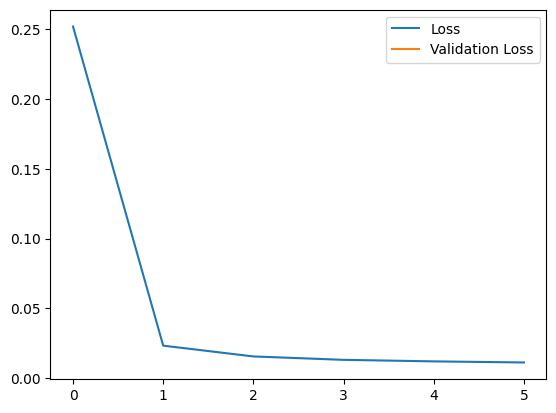

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [9]:
import numpy as np

def predict_sequence(encoder_model, decoder_model, input_seq, max_decoder_length, target_tokenizer):
    # 1️⃣ Passar a entrada pelo encoder
    states_value = encoder_model.predict(input_seq)

    # 2️⃣ Criar um array inicial para o decoder (apenas o token <START>)
    target_seq = np.zeros((1, 1, num_classes))  # 1 batch, 1 timestep, num_classes
    target_seq[0, 0, target_tokenizer.word_index['<START>']] = 1  # Definir <START>

    decoded_sentence = ""
    
    for _ in range(max_decoder_length):
        # 3️⃣ Fazer a predição de um token
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        
        # 4️⃣ Escolher o token com maior probabilidade
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = target_tokenizer.index_word.get(sampled_token_index, "")

        # 5️⃣ Se for <END>, para a geração
        if sampled_word == "<END>":
            break

        decoded_sentence += " " + sampled_word

        # 6️⃣ Atualizar a sequência de entrada do decoder com a nova palavra gerada
        target_seq = np.zeros((1, 1, num_classes))
        target_seq[0, 0, sampled_token_index] = 1

        # 7️⃣ Atualizar os estados internos do decoder
        states_value = [h, c]

    return decoded_sentence.strip()

In [11]:
# Create encoder model for inference
# Extract the encoder part of the model
encoder_inputs = Input(shape=(seq_length, input_dim))
x = Dense(embed_dim)(encoder_inputs)

# Add encoder transformer layers (reusing the transformer_encoder from previous cells)
for _ in range(2):
    x = transformer_encoder(x, embed_dim, num_heads, ff_dim, dropout_rate)

encoder_outputs = x
encoder_model = Model(encoder_inputs, encoder_outputs)

# Create decoder model for inference
decoder_inputs = Input(shape=(seq_length, num_classes))
encoder_output_inputs = Input(shape=(seq_length, embed_dim))
x = Dense(embed_dim)(decoder_inputs)

# Add decoder transformer layers
for _ in range(2):
    x = transformer_decoder(x, encoder_output_inputs, embed_dim, num_heads, ff_dim, dropout_rate)

decoder_outputs = Dense(64)(x)
decoder_outputs = LeakyReLU(alpha=0.1)(decoder_outputs)
decoder_outputs = Dense(num_classes, activation="softmax")(decoder_outputs)

# Final decoder model for inference
decoder_model = Model([decoder_inputs, encoder_output_inputs], decoder_outputs)

def decode_sequence(input_seq):
    # Encode the input sequence
    encoder_output = encoder_model.predict(input_seq)
    
    # Start with an empty sequence
    target_seq = np.zeros((1, seq_length, num_classes))
    
    # Set initial state (all zeros except for start position)
    # For simplicity, we'll use 0 as the start token index
    target_seq[0, 0, 0] = 1.0
    
    # Collect predictions
    predicted_sequence = np.zeros((1, seq_length, num_classes))
    
    # Generate the sequence one step at a time
    for i in range(seq_length):
        # Predict next token
        output = decoder_model.predict([target_seq, encoder_output])
        
        # Store prediction for this timestep
        predicted_sequence[0, i] = output[0, i]
        
        # For next step prediction, feed the current output back as input
        if i < seq_length - 1:
            target_seq[0, i+1] = output[0, i]
    
    # Convert from one-hot encoding to class indices
    predicted_indices = np.argmax(predicted_sequence[0], axis=-1)
    
    # Convert class indices to mudra names
    mudra_names = [label_encoder.classes_[idx] for idx in predicted_indices]
    
    # Return the most common predicted mudra (majority vote)
    from collections import Counter
    most_common = Counter(mudra_names).most_common(1)[0][0]
    
    return most_common


c:\Users\drodm\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [18]:
test_input = X_test[100:101]  # Get a single input sequence
output = decode_sequence(test_input)
print("Predicted:", output)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted: Unknown/Transition


In [ ]:
# Test model on multiple examples
num_samples = 10

print("Evaluating model on multiple test examples...")
print("-" * 50)

correct_count = 0
for i in range(num_samples):
    # Get test input
    test_input = X_test[i:i+1]
    
    # Make prediction
    prediction = decode_sequence(test_input)
    
    # Get true label (most common class in sequence)
    true_labels = y_test[i]
    unique_values, counts = np.unique(true_labels, return_counts=True)
    most_common_idx = unique_values[np.argmax(counts)]
    true_mudra = label_encoder.classes_[most_common_idx]
    
    # Check if prediction is correct
    is_correct = prediction == true_mudra
    if is_correct:
        correct_count += 1
    
    # Display result
    print(f"Example {i+1}:")
    print(f"  True Mudra: {true_mudra}")
    print(f"  Predicted: {prediction}")
    print(f"  {'✓ Correct' if is_correct else '✗ Incorrect'}")
    print("-" * 50)

# Display overall accuracy
accuracy = correct_count / num_samples
print(f"Overall accuracy: {accuracy:.2f} ({correct_count}/{num_samples})")

In [ ]:
# Test model on multiple examples
num_samples = 10

print("Evaluating model on multiple test examples...")
print("-" * 50)

correct_count = 0
for i in range(num_samples):
    # Get test input
    test_input = X_test[i:i+1]
    
    # Make prediction
    prediction = decode_sequence(test_input)
    
    # Get true label (most common class in sequence)
    true_labels = y_test[i]
    unique_values, counts = np.unique(true_labels, return_counts=True)
    most_common_idx = unique_values[np.argmax(counts)]
    true_mudra = label_encoder.classes_[most_common_idx]
    
    # Check if prediction is correct
    is_correct = prediction == true_mudra
    if is_correct:
        correct_count += 1
    
    # Display result
    print(f"Example {i+1}:")
    print(f"  True Mudra: {true_mudra}")
    print(f"  Predicted: {prediction}")
    print(f"  {'✓ Correct' if is_correct else '✗ Incorrect'}")
    print("-" * 50)

# Display overall accuracy
accuracy = correct_count / num_samples
print(f"Overall accuracy: {accuracy:.2f} ({correct_count}/{num_samples})")

Evaluating model on multiple test examples...
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Example 1:
  True Mudra: Uttarabodhi
  Predicted: Dhyana
  ✗ Incorrect
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━

: 